# Decision trees - classification

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

from feature_engine.selection import SelectBySingleFeaturePerformance

### Load data

In [2]:
# load titanic dataset

df = pd.read_csv('../titanic_trees.csv')

df.head()

,pclass,sibsp,parch,sex,embarked,cabin,survived
0,1,0,0,0,0,0,1
1,1,1,2,1,0,1,1
2,1,1,2,0,0,1,0
3,1,1,2,1,0,1,0
4,1,1,2,0,0,1,0


### Split data

In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("survived", axis=1),
    df["survived"],
    test_size=0.15,
    random_state=1,
)

X_train.shape, X_test.shape

((1112, 6), (197, 6))

### Visualize data

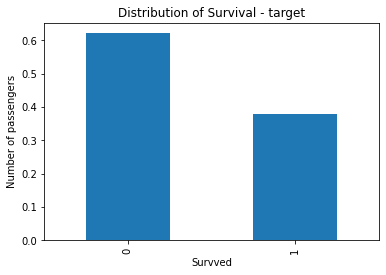

In [4]:
# Display the target distribution

y_train.value_counts(normalize=True).plot.bar()
plt.xlabel("Survved")
plt.ylabel("Number of passengers")
plt.title("Distribution of Survival - target")
plt.show()

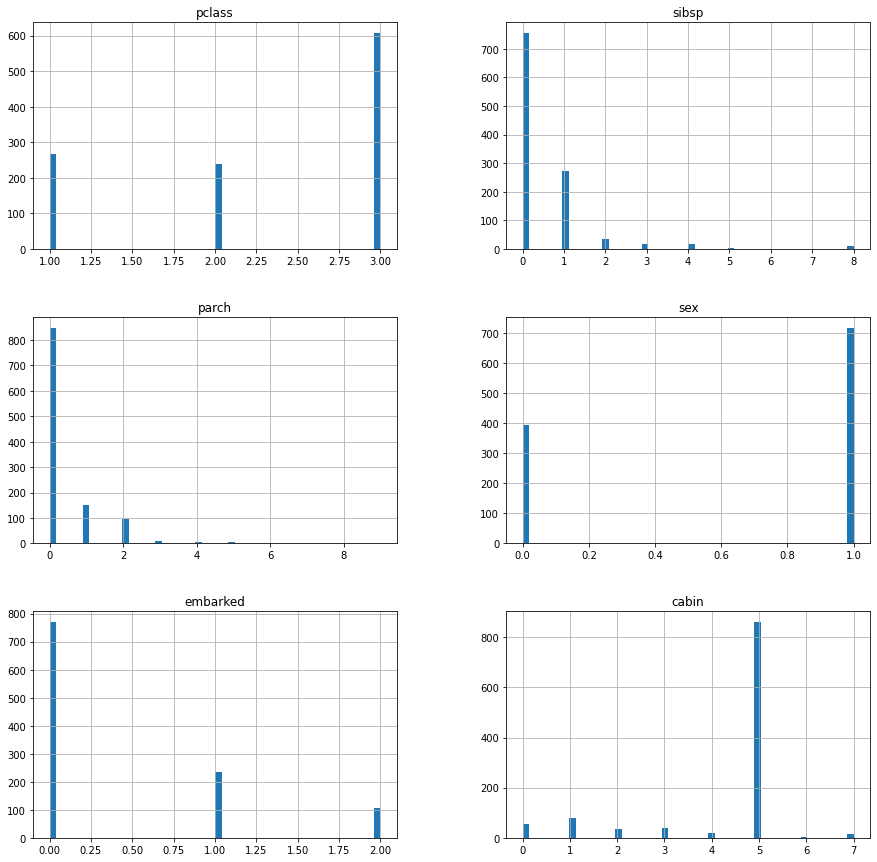

In [5]:
# Display the variables distribution

X_train.hist(bins=50, figsize=(15, 15))
plt.show()

## Decision tree

In [6]:
# fit model

tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [7]:
# Accuracy in train set

tree.score(X_train, y_train)

0.7985611510791367

In [8]:
# Accuracy in test set

tree.score(X_test, y_test)

0.7868020304568528

The model correctly predicts ~79% of the outcomes.

In [9]:
baseline = 1 - y_train.mean()
baseline

0.6214028776978417

A baseline model that selects the majority class (not survived) has 62% accuracy. 

Our model has 79%, which means that is better than the baseline, that is, better than just predicting the majority class.

## Plot tree

This is how the tree makes the decisions.

In [10]:
y_train.value_counts(), y_train.mean()

(survived
 0    691
 1    421
 Name: count, dtype: int64,
 0.37859712230215825)

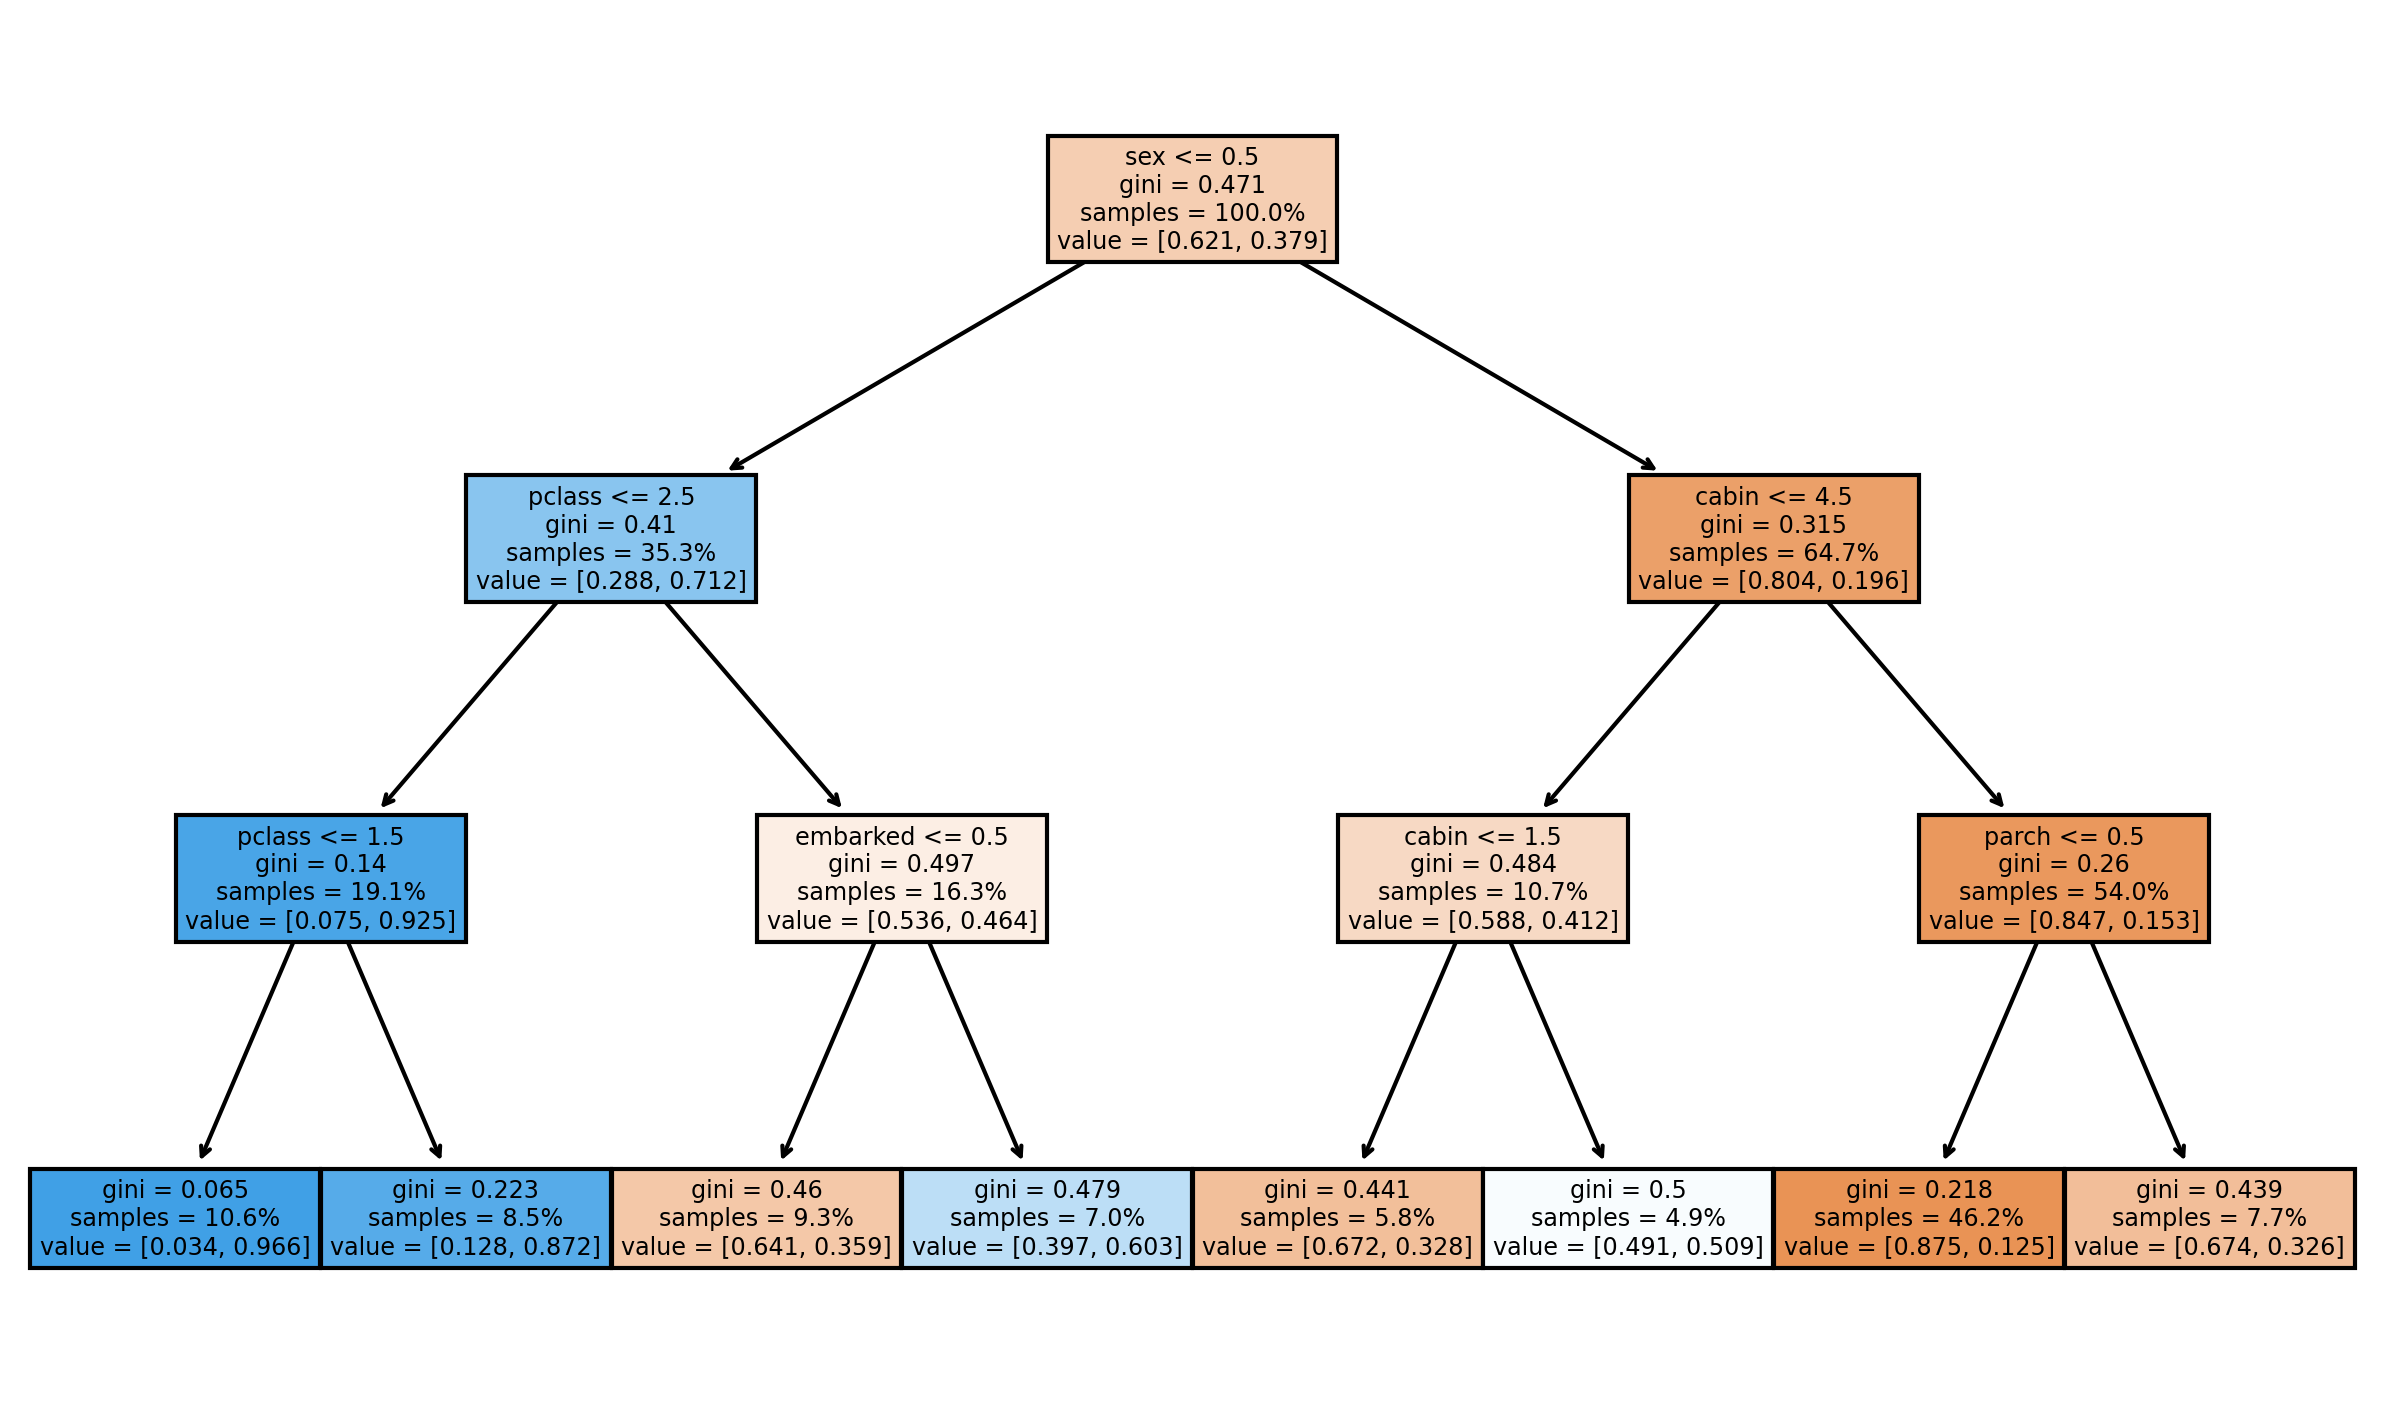

In [11]:
plt.figure(figsize=(10, 6), dpi=300)

plot_tree(
    decision_tree = tree,
    feature_names=X_train.columns.to_list(),
    filled=True,
    proportion=True, # proportion of observations at each node
)

plt.show()

**Note**

- The number of samples per node decreases as we go along the nodes.
- Value is the number/fraction of observations that died or survived.
- Value in the leaves is the prediction of the decision tree (one for each class).

The decision tree outputs discrete predictions.

The prediction is the mean target value at each node.

## Global explanations - feature importance

Weighted decrease in impurity at each node contributed by each feature (normalized to 1, that is, the sum of the importances = 1)

https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d6e0a3e8ddf92a7e5561245224dab102/sklearn/tree/_tree.pyx#L1134-L1138

```
importances[node.feature] += (
    node.weighted_n_node_samples * node.impurity -
    left.weighted_n_node_samples * left.impurity -
    right.weighted_n_node_samples * right.impurity)
node += 1
```

In [12]:
# The sum of the importances = 1

pd.Series(tree.feature_importances_).sum()

1.0

In [13]:
global_exp = pd.Series(tree.feature_importances_, index=tree.feature_names_in_)

global_exp

pclass      0.207205
sibsp       0.000000
parch       0.029166
sex         0.663459
embarked    0.025738
cabin       0.074431
dtype: float64

As expected from the tree diagram, gender is the most important feature, but other features help refine the estimation.

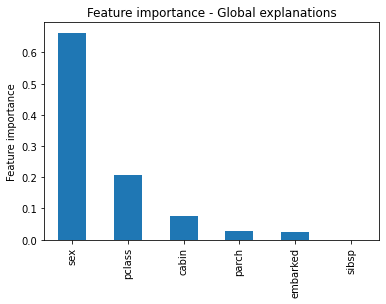

In [14]:
global_exp = pd.Series(tree.feature_importances_, index=tree.feature_names_in_)

global_exp.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

## Single feature classifiers

Multi-colinearity and feature interaction will affect the importance shown by the trees, so to look at each feature individually, we can train single feature classifiers.

In [15]:
sel = SelectBySingleFeaturePerformance(
    estimator = tree, 
    scoring='accuracy', 
    cv=3, 
    threshold=None,
)

sel.fit(X_train, y_train)

SelectBySingleFeaturePerformance(estimator=DecisionTreeClassifier(max_depth=3),
                                 scoring='accuracy')

In [16]:
pd.Series(sel.feature_performance_).sort_values(ascending=False)

sex         0.771550
cabin       0.695160
pclass      0.681657
parch       0.645667
sibsp       0.622314
embarked    0.621398
dtype: float64

Text(0.5, 1.0, 'Single feature classifiers')

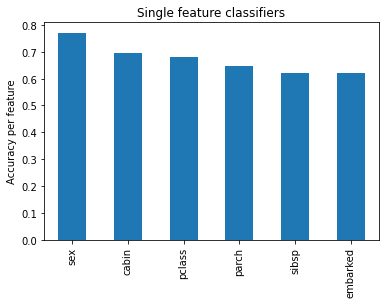

In [17]:
pd.Series(sel.feature_performance_).sort_values(ascending=False).plot.bar()
plt.ylabel("Accuracy per feature")
plt.title("Single feature classifiers")

From this plot, we see that gender is almost enough to predict survival on the titanic. A decision tree trained using that feature shows the same accuracy as the decision tree trained using all features.

But, other variables, individually, are also good predictors of survival. The class for example, which is a proxy for wealth is a good predictor, and surprisingly, whether the person has a parent or child, or the port of embarkment are also good predictors when we remove the effect of gender.